In [19]:
from VariNet.utils.visualization import *
from VariNet.models.vae import MnistVAE
from VariNet.models.avae import MnistAVAE
from VariNet.utils.datasets import binary_mnist_dataloaders

import torch
import json
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.decomposition import PCA

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

import matplotlib as mlp

# Figure dpi
mlp.rcParams['figure.dpi'] = 100

In [54]:
# Mnist test dataloader
dataloader, test_dataloader = binary_mnist_dataloaders(data_root = './data',
                                              batch_size = 64,
                                              image_size = 32,
                                              download=False)

In [4]:
# Load VAE model
# Load model parameters
with open('trained_models/VAE/params.json') as f:
    params = json.load(f)

# Load model weights
vae = MnistVAE(
            in_channels=params['input_channels'],
            input_size=params['image_size'],
            z_dim=params['z_dim'],
            decoder_features=params['decoder_features'],
            encoder_features=params['encoder_features'],
            device=device)

vae.load_state_dict(torch.load('trained_models/VAE/model.pth', map_location=torch.device(device)))
vae.to(device)

vae.eval()
latent_representations_list_vae = []
labels_list_vae = []
with torch.no_grad():
    for batch in dataloader:
        imgs, labels = batch
        batch_size = imgs.shape[0]
        x = imgs.to(device)

        posterior = vae.encode(x)
        z = posterior.mode()
        latent_representations_list_vae.append(z.cpu())
        labels_list_vae.extend(labels.cpu())

latent_representations_vae = torch.cat(latent_representations_list_vae, dim=0)
labels_vae = torch.tensor(labels_list_vae)

print('Ready :)')

Ready :)


In [5]:
# Load AVAE model
# Load model parameters
with open('trained_models/AVB/params.json') as f:
    params = json.load(f)

# Load model weights
avae = MnistAVAE(
            in_channels=params['input_channels'],
            input_size=params['image_size'],
            z_dim=params['z_dim'],
            decoder_features=params['decoder_features'],
            encoder_features=params['encoder_features'],
            device=device)

avae.load_state_dict(torch.load('trained_models/AVB/model.pth', map_location=torch.device(device)))
avae.to(device)

avae.eval()
latent_representations_list_avae = []
labels_list_avae = []
with torch.no_grad():
    for batch in dataloader:
        imgs, labels = batch
        batch_size = imgs.shape[0]
        x = imgs.to(device)

        z, _, _ = avae.encode(x)
        latent_representations_list_avae.append(z.cpu())
        labels_list_avae.extend(labels.cpu())

latent_representations_avae = torch.cat(latent_representations_list_avae, dim=0)
labels_avae = torch.tensor(labels_list_avae)

In [8]:
# Latent space visualization with PCA
pca_vae = PCA(n_components=2)
pca_vae.fit(latent_representations_vae)

latent_representations_pca_vae = pca_vae.transform(latent_representations_vae)

pca_avae = PCA(n_components=2)
pca_avae.fit(latent_representations_avae)

latent_representations_pca_avae = pca_avae.transform(latent_representations_avae)

In [9]:
# Latent space visualization with t-SNE
tsne_vae = TSNE(perplexity=20, verbose=0)
tsne_representations_vae = tsne_vae.fit_transform(latent_representations_vae)

tsne_avae = TSNE(perplexity=20, verbose=0)
tsne_representations_avae = tsne_avae.fit_transform(latent_representations_avae)

In [41]:
def scatter(data, labels, title, path):
    # Scatter PCA - VAE
    fig = plt.figure(figsize=(7, 6))

    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10', alpha=1, s = 1)
    plt.colorbar()
    plt.title(title)

    #Remove ticks
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

    plt.savefig(path, dpi=300, bbox_inches='tight')
    plt.show()

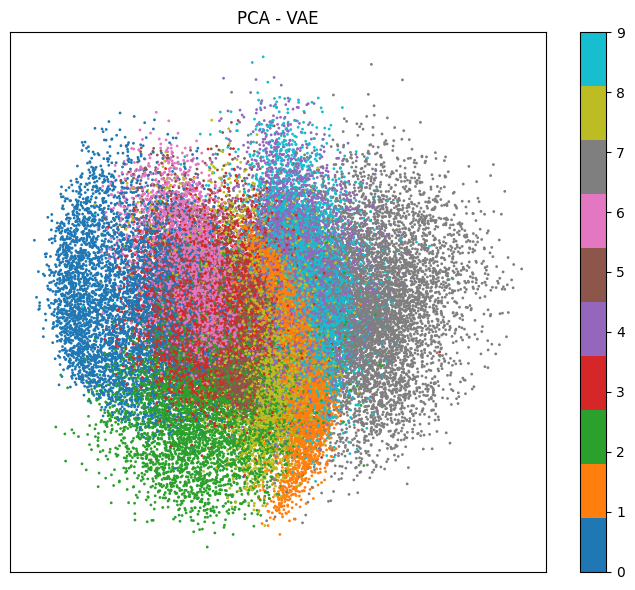

In [42]:
scatter(latent_representations_pca_vae, labels_vae, 'PCA - VAE', 'figures/PCA_VAE.png')

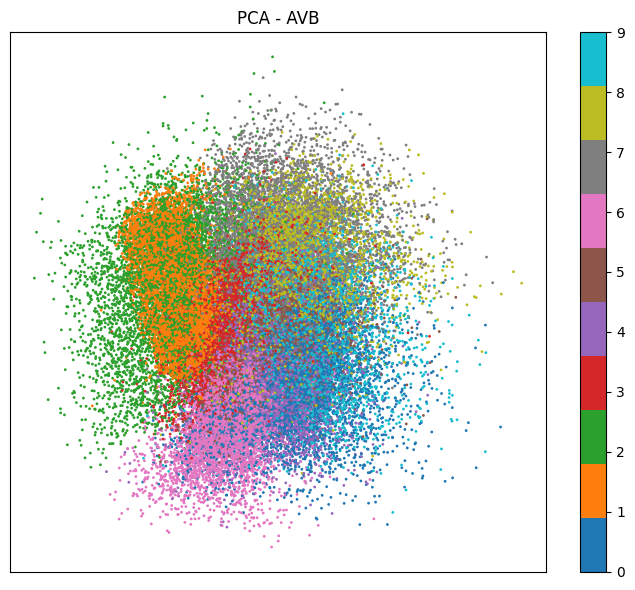

In [43]:
scatter(latent_representations_pca_avae, labels_avae, 'PCA - AVB', 'figures/PCA_AVB.png')

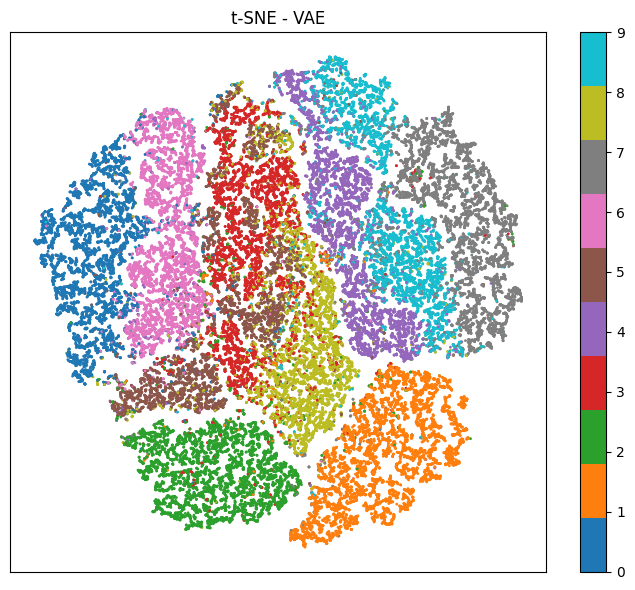

In [44]:
scatter(tsne_representations_vae, labels_vae, 't-SNE - VAE', 'figures/tSNE_VAE.png')

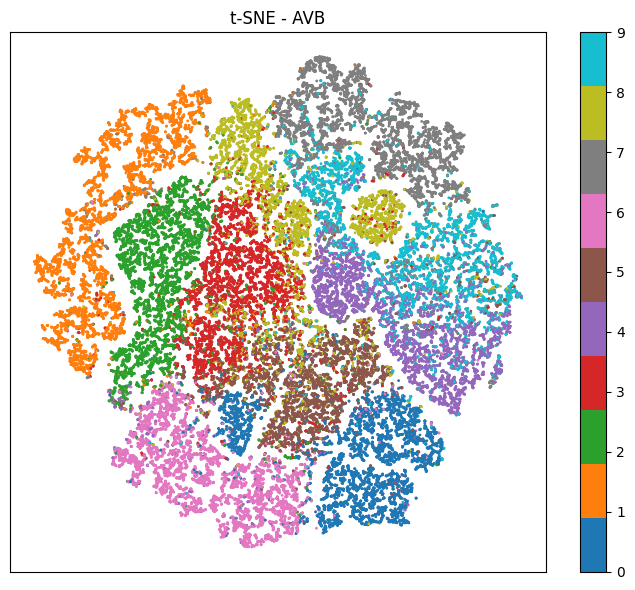

In [45]:
scatter(tsne_representations_avae, labels_avae, 't-SNE - AVB', 'figures/tSNE_AVB.png')

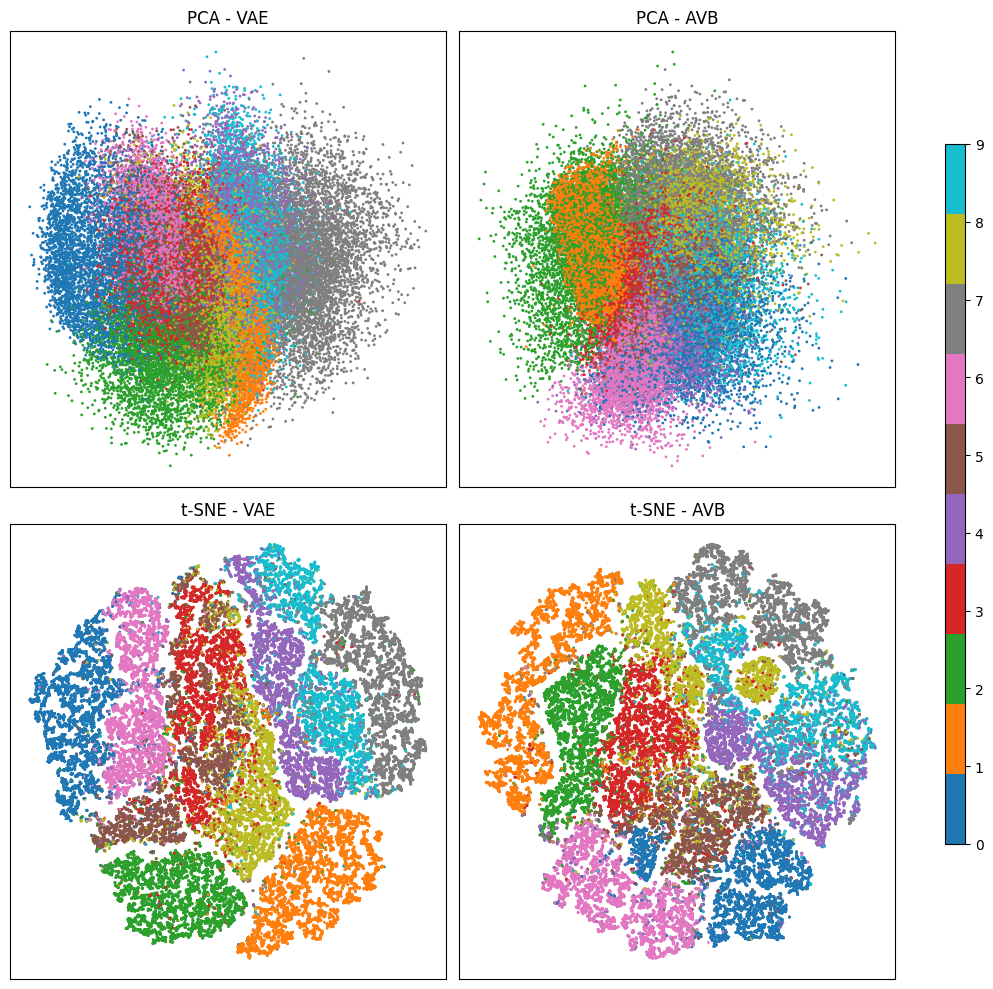

In [49]:
# Create 2x2 plot with PCA and t-SNE
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].scatter(latent_representations_pca_vae[:, 0], latent_representations_pca_vae[:, 1], c=labels_vae, cmap='tab10', alpha=1, s = 1)
axs[0, 0].set_title('PCA - VAE')

axs[0, 1].scatter(latent_representations_pca_avae[:, 0], latent_representations_pca_avae[:, 1], c=labels_avae, cmap='tab10', alpha=1, s = 1)
axs[0, 1].set_title('PCA - AVB')

axs[1, 0].scatter(tsne_representations_vae[:, 0], tsne_representations_vae[:, 1], c=labels_vae, cmap='tab10', alpha=1, s = 1)
axs[1, 0].set_title('t-SNE - VAE')

axs[1, 1].scatter(tsne_representations_avae[:, 0], tsne_representations_avae[:, 1], c=labels_avae, cmap='tab10', alpha=1, s = 1)
axs[1, 1].set_title('t-SNE - AVB')

#Remove ticks
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

# Colorbar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(axs[0, 0].collections[0], cax=cbar_ax)

plt.savefig('figures/latent_space.png', dpi=100, bbox_inches='tight')
plt.show()

In [139]:
def plot_reconstructions(x, x_vae, x_avae, n=5, path='figures/reconstructions.png', title='Reconstructions'):
    fig, axs = plt.subplots(6, n//2, figsize=(n//2, 6))

    for i in range(n):
        if i%2 == 0:
            axs[2, i//2].imshow(x[i].squeeze(), cmap='gray')
            axs[0, i//2].imshow(x_vae[i].squeeze(), cmap='gray')
            axs[4, i//2].imshow(x_avae[i].squeeze(), cmap='gray')
        else:
            axs[3, i//2].imshow(x[i].squeeze(), cmap='gray')
            axs[1, i//2].imshow(x_vae[i].squeeze(), cmap='gray')
            axs[5, i//2].imshow(x_avae[i].squeeze(), cmap='gray')

    # Remove ticks
    for ax in axs.flat:
        ax.set_xticks([])
        ax.set_yticks([])

    # Remve horizontal space between axes
    fig.subplots_adjust(hspace=0, wspace=0)

    axs[0, 0].set_ylabel('VAE')
    axs[2, 0].set_ylabel('Original')
    axs[4, 0].set_ylabel('AVB')

    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(path, dpi=300, bbox_inches='tight')

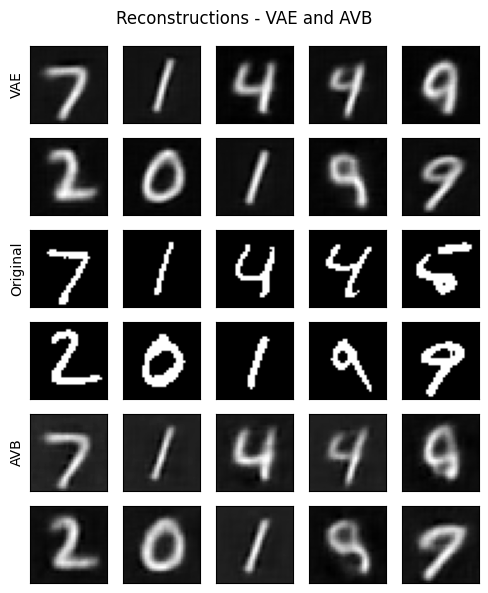

In [140]:
# Reconstructions - VAE
vae.eval()

with torch.no_grad():
    batch = next(iter(test_dataloader))
    imgs, labels = batch
    batch_size = imgs.shape[0]
    x = imgs.to(device)

    posterior = vae.encode(x)
    z = posterior.mode()
    x_hat_vae = vae.decode(z).mode()

    x_hat_vae = x_hat.cpu()

# Reconstructions - AVB
avae.eval()

with torch.no_grad():
    batch_size = imgs.shape[0]
    x = imgs.to(device)

    z, _, _ = avae.encode(x)
    x_hat_avae = avae.decode(z).mode()

    x = x.cpu()
    x_hat_avae = x_hat_avae.cpu()

plot_reconstructions(x, x_hat, x_hat_avae, n=10, path='figures/reconstructions.png', title='Reconstructions - VAE and AVB')

In [151]:
def save_images(images, title, path):
    a = int(np.sqrt(images.shape[0]))
    b = images.shape[0] // a
    images = images.detach().to('cpu').squeeze()

    fig, ax = plt.subplots(a, b, figsize=(b-0.1, a))
    for i in range(a):
        for j in range(b):
            ax[i, j].imshow(images[i*b+j], cmap='gray')
            ax[i, j].axis('off')

    fig.subplots_adjust(wspace=0, hspace=0)
    fig.savefig(path, dpi=300)
    plt.show()

def interpolate(model, z_dim, device, path, title):
    z_1 = torch.randn(1, z_dim).to(device)
    z_2 = torch.randn(1, z_dim).to(device)
    z_3 = torch.randn(1, z_dim).to(device)
    z_4 = torch.randn(1, z_dim).to(device)

    lengths = torch.linspace(0., 1., 10).unsqueeze(1).to(z_1.device)

    z_h_top = z_2*lengths + z_1*(1-lengths)
    z_h_down = z_4*lengths + z_3*(1-lengths)

    for i in range(10):
        z_ver = z_h_top[i]*lengths + z_h_down[i]*(1-lengths)
        output = model.decode(z_ver).mode()
        if i == 0:
            grid = output
        else:
            grid = torch.cat((grid, output), 0)

    save_images(grid, title, path)

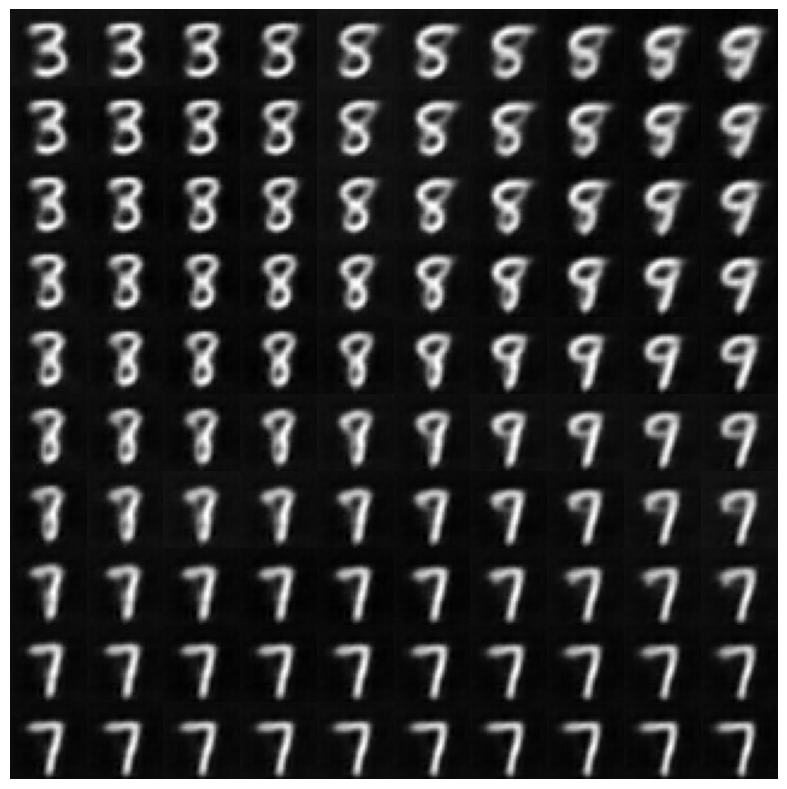

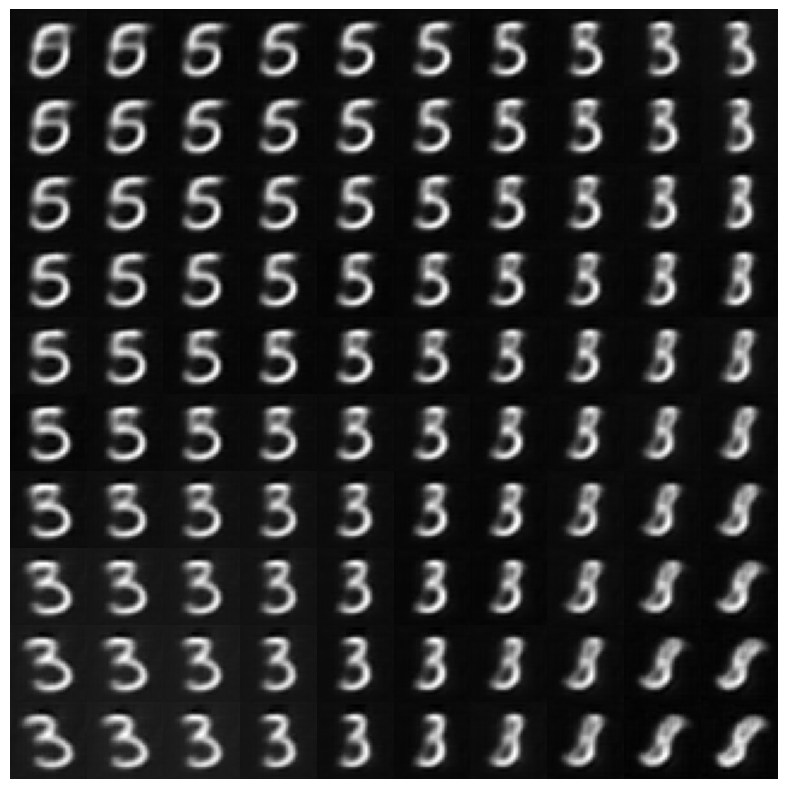

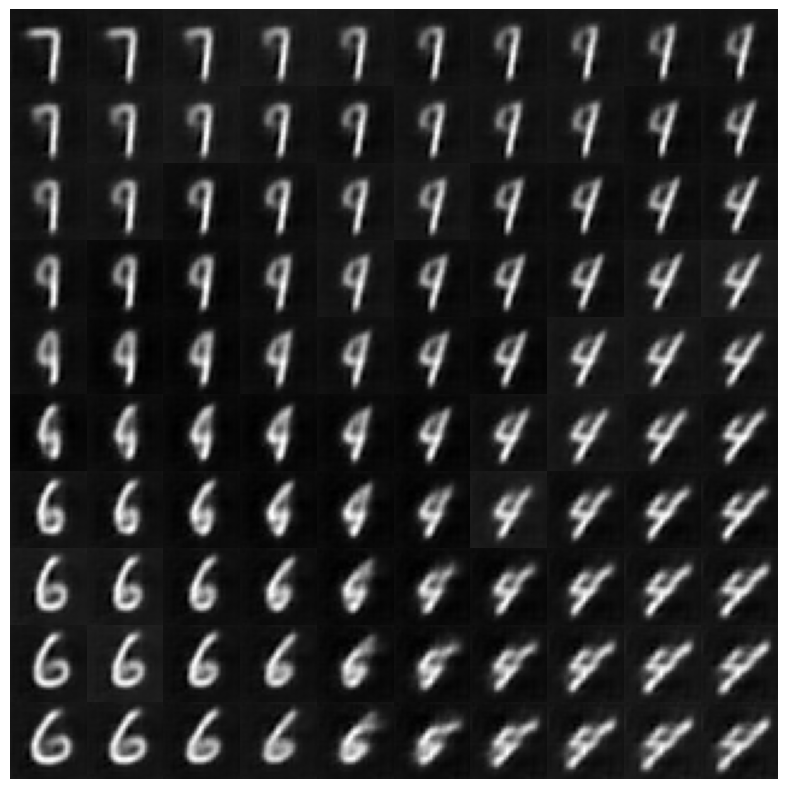

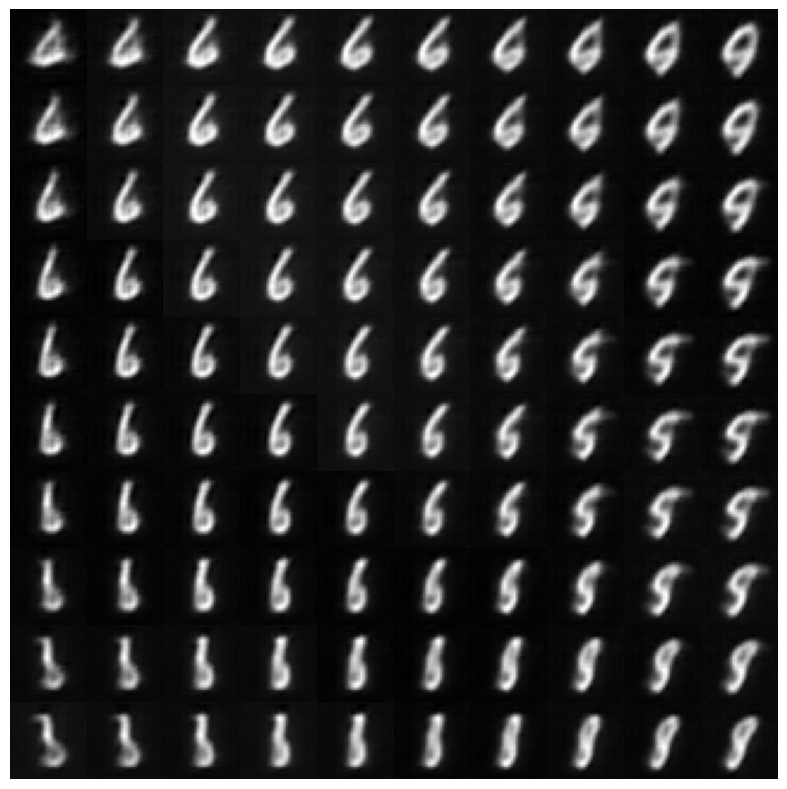

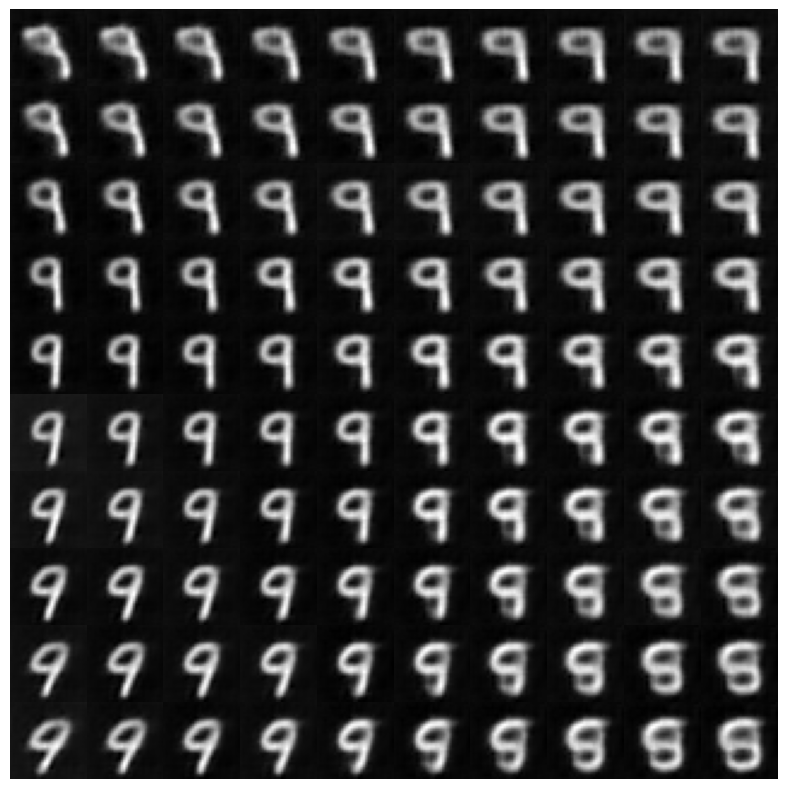

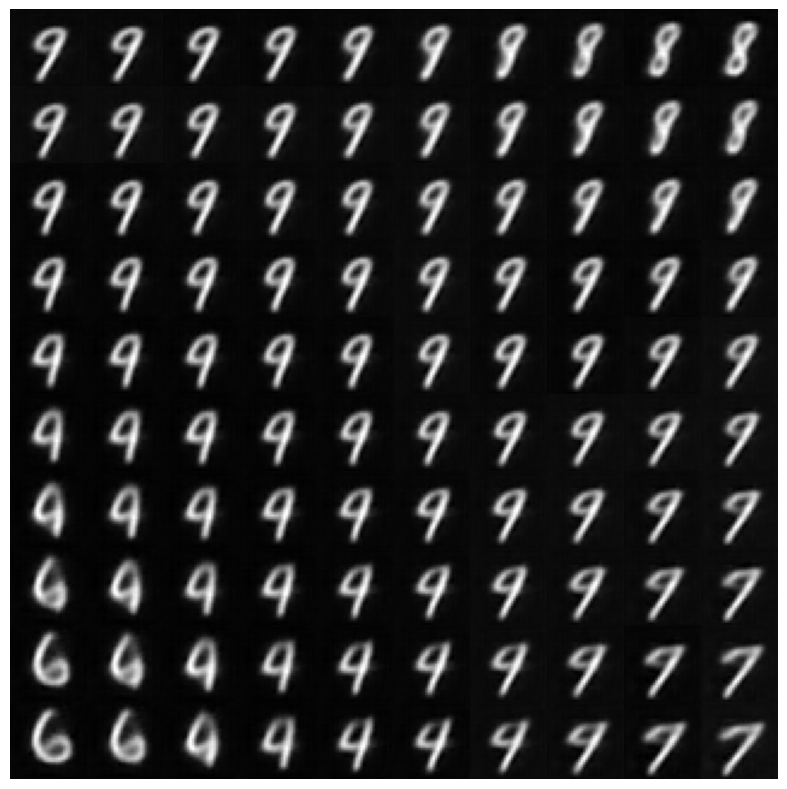

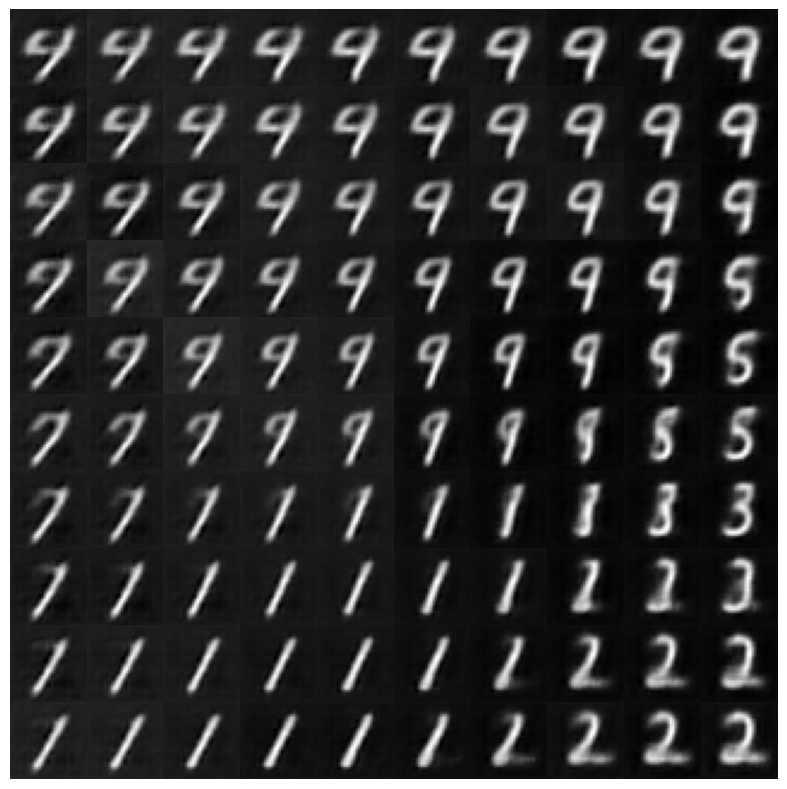

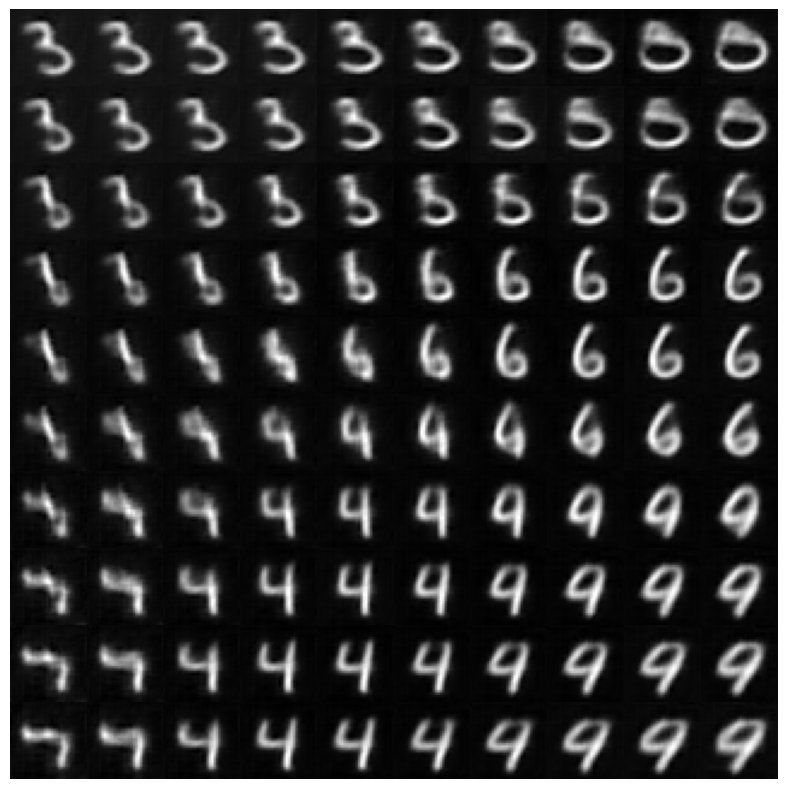

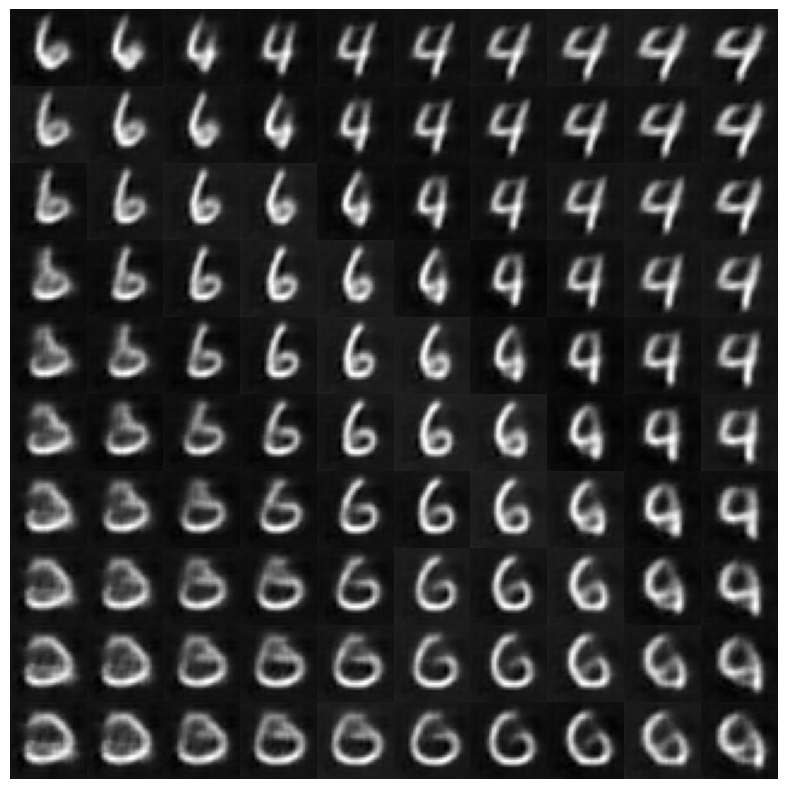

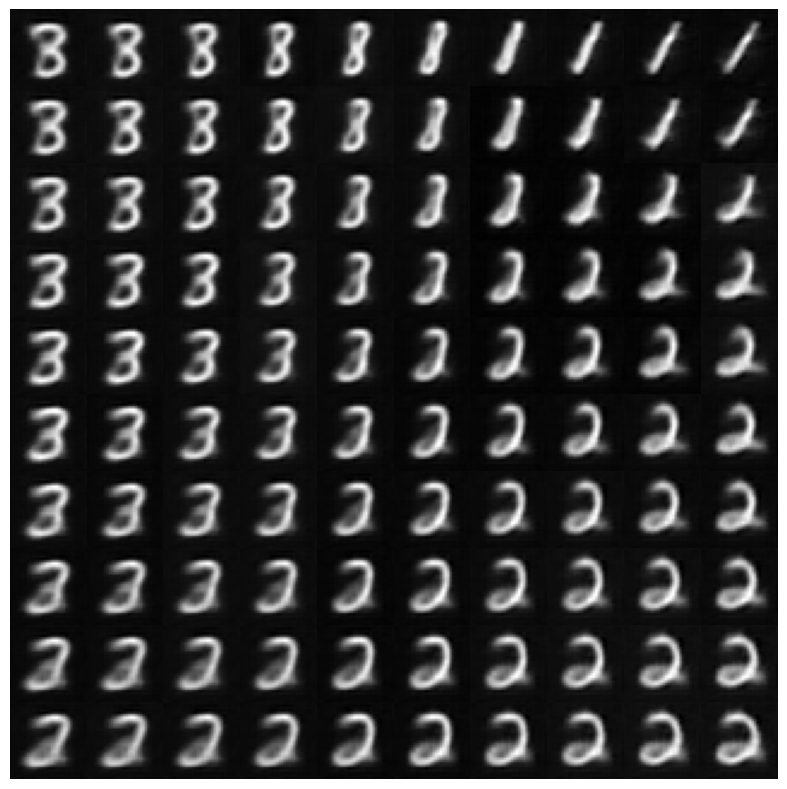

In [152]:
# Interpolations

for i in range(5):
    interpolate(avae, 4, device, path = f'figures/interpolation_avae_{i}.png', title='Interpolation - AVB')
    interpolate(vae, 4, device, path = f'figures/interpolation_vae_{i}.png', title='Interpolation - VAE')